In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor

A simple simulation experimental setup:
$$f(x)=x\log x,\;x\in[0,1],\;X|Y=y \sim \textrm{Beta}(\alpha(y),\beta(y)).$$
$f$ has a minimum at $x=1/e$ (no local minima). We can compute
$$g(y)=\mathbb E_{X|Y=y}\left[X\log X\right]=\frac{\alpha(y)}{\alpha(y)+\beta(y)}\left[\psi(\alpha(y)+1)-\psi(\alpha(y)+\beta(y)+1)\right],$$
where $\psi$ is the digamma function. To complete the setup need to choose some functions $\alpha:\mathcal Y\to (0,+\infty)$, $\beta:\mathcal Y\to (0,+\infty),$ e.g. take $\mathcal Y=\mathbb R^3$ and
$$\alpha(y)=\exp(a^\top y+c),\;\beta(y)=\exp(b^\top y+d),$$
or similar.

Nb. the bounded domain of $X$ might need to be built into the kernel construction when estimating CME $X|Y$, e.g. one can use
$$k(x,x')=\exp\left(-\frac{1}{2\gamma^2}\left(\log\frac{x}{1-x}-\log\frac{x'}{1-x'}\right)^2\right),\quad x,x'\in(0,1).$$


In [2]:
def alpha(y,a=1,c=0):
    return np.exp(a * y +c)

def beta(y, b=1, d=0):
    return np.exp(b* y + d)

def func(x):
    return x * np.log(x)

def g(y,a=1,b=0,c=1,d=0):
    alpha_value = alpha(y,a,c)
    beta_value = beta(y,b,d)
    g_value = alpha_value/(alpha_value+beta_value) * (digamma(alpha_value + 1) - digamma(alpha_value + beta_value + 1))
    return g_value

In [3]:
def generate_D1(n, a,b,c,d):
    ys = np.random.uniform(0,1,n)
    alphas = []
    betas = []
    xs = []
    fs = []
    for i in ys:
        alpha_value = alpha(i,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(i,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
    plt.plot(ys, xs, '.')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title('D1')
    
    plt.legend()
    return np.asarray(xs), np.asarray(ys)
    

def generate_D2(m, a,b,c,d, sigma=0.01, plot=True):
    ys = np.random.uniform(0,1,m)
    zs = []
    
    alphas = []
    betas = []
    xs = []
    fs = []
    for y in ys:
        alpha_value = alpha(y,a,c)
        alphas.append(alpha_value)
        
        beta_value = beta(y,b,d)
        betas.append(beta_value)
        x_value = np.random.beta(alpha_value, beta_value)
        xs.append(x_value)
        fs.append(func(x_value))  
        
        g_value = g(y, a,b,c,d)
        z_value = g_value + np.random.normal(0, sigma)
        zs.append(z_value)
        
    if plot:    
        # plt.plot(ys, xs, '.', label = 'x')
        # plt.plot(fs, xs, '.', label = 'f(x)')
        
        plt.plot(ys, zs,'.')
        plt.xlabel('y')
        plt.ylabel('z (aggregated feedback)')
        plt.title('D2')
        
    return np.asarray(ys), np.asarray(zs)

In [4]:
a = 0.1
b = 4
c = 2
d = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


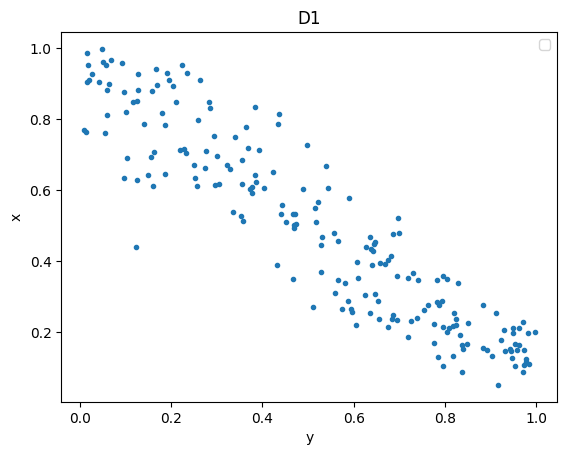

In [5]:
xs, ys = generate_D1(200,a,b,c,d)

Text(0, 0.5, 'f(x)')

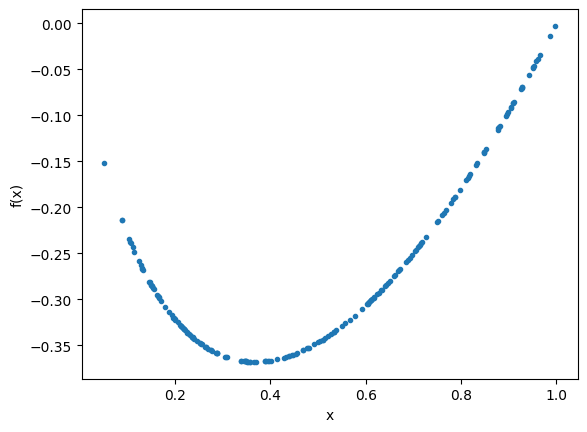

In [6]:
plt.plot(xs, func(xs), '.')
plt.xlabel('x')
plt.ylabel('f(x)')

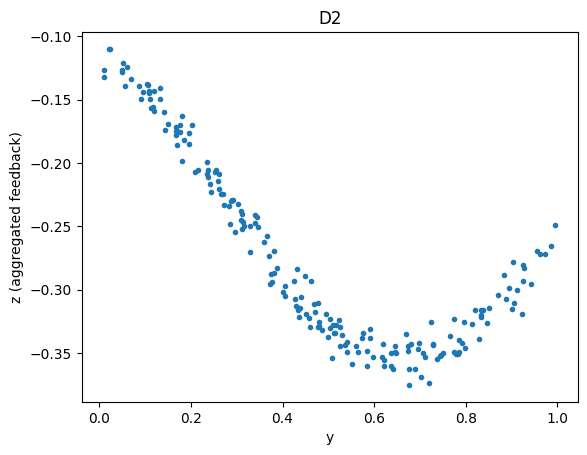

In [7]:
ys2, zs = generate_D2(200, a,b,c,d, 0.01)

In [8]:
muz, sigmaz = zs.mean(), zs.std()
zs = (zs - muz) / sigmaz

In [9]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp_mz.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys))
model = build_model(cfg['model'])

In [10]:
groundtruth_individuals = torch.tensor(np.linspace(1e-5,1-1e-5,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=100,
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")
/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/bouabid/.pyenv/versions/3.8.0/envs/sandbox/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [11]:
predict_kwargs = {'name': cfg['model']['name'],
                  'model': model.eval().cpu(),
                  'individuals': groundtruth_individuals}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

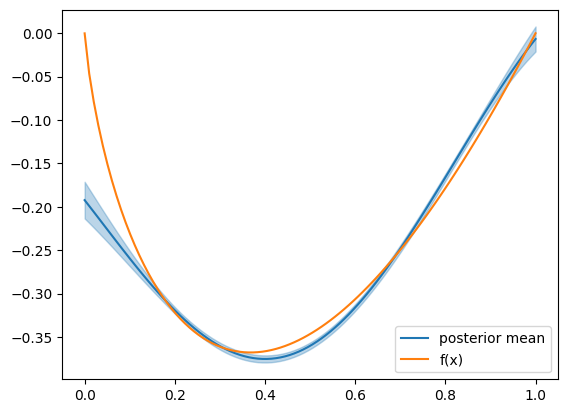

In [12]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [ ]:
ys = torch.from_numpy(ys).float()

predict_kwargs = {'name': cfg['model']['name'],
                  'model': model.eval().cpu(),
                  'individuals': torch.from_numpy(xs).float()}
individuals_posterior = predict(predict_kwargs)

In [78]:
with torch.no_grad():
    Kd = sigmaz**2 * individuals_posterior.covariance_matrix

    N = len(ys)
    λ = 0.01
    Lλ = model.bag_kernel(ys, ys).add_diag(λ * N * torch.ones(N))
    chol = torch.linalg.cholesky(Lλ.evaluate())
    
    Lys_ys2 = model.bag_kernel(ys, ys2).evaluate()
    Lλinv_Lys_ys2 = torch.cholesky_solve(Lys_ys2, chol)
    
    B = Lλinv_Lys_ys2.T @ Kd @ Lλinv_Lys_ys2 # this is the term in (12)

# UCB design

In [21]:
def D2_oracle(y, sigma=0.01):
    g_value = g(y)
    z_value = g_value + np.random.normal(0, sigma)
    return z_value

def h_fit(xs, ys, ):
    # ucb(x) = h(y) + noise
    xs = xs.reshape(-1,1)
    gpr = GaussianProcessRegressor(random_state=0).fit(xs,f(xs))
    means, stds = gpr.predict(xs, return_std=True)
    alpha = 5 * 1e4
    ucbs = means + alpha * stds

    # plt.plot(xs, f(xs), '.', label = 'f')
    # plt.plot(xs, means, '.', label = 'mean')
    # plt.plot(xs, 5 * 1e4 * stds, '.', label = 'std')
    # plt.plot(xs, ucbs, '.', label = 'ucb')
    # plt.xlabel('x')
    # plt.legend()
    
    ys = ys.reshape(-1,1)
    pred_space = np.linspace(0,1,100).reshape(-1,1)
    gpr_y_ucb = GaussianProcessRegressor(random_state=0).fit(ys,ucbs)
    means_y_ucb, stds_y_ucb = gpr_y_ucb.predict(pred_space, return_std=True)

    # plt.plot(ys, ucbs, '.')
    # plt.plot(pred_space, means_y_ucb, '.', label = 'mean')
    # plt.plot(pred_space, 1e4 * stds_y_ucb, '.', label = 'std')
    # plt.xlabel('y')
    # plt.legend()